# Method 2 - Best Ideas High Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

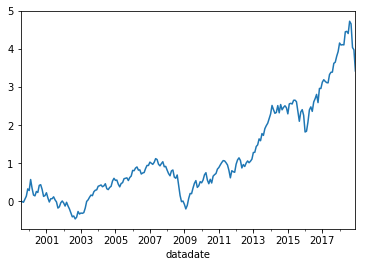

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.329459
2000-12-31   -0.131598
2001-12-31   -0.122882
2002-12-31   -0.338114
2003-12-31    0.946912
2004-12-31    0.231747
2005-12-31    0.037236
2006-12-31    0.166365
2007-12-31   -0.012522
2008-12-31   -0.473375
2009-12-31    0.502104
2010-12-31    0.217282
2011-12-31   -0.045458
2012-12-31    0.195540
2013-12-31    0.502790
2014-12-31    0.091067
2015-12-31   -0.057604
2016-12-31    0.215644
2017-12-31    0.244370
2018-12-31   -0.102986
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     430.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.79e-105
Time:                        02:31:37   Log-Likelihood:                 537.98
No. Observations:                 234   AIC:                            -1066.
Df Residuals:                     229   BIC:                            -1049.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      3.141      0.002       0.002       0.009
mktrf          1.0230      0.046     22.345      0.000       0.933       1.113
me             0.5109      0.053      9.593      0.000       0.406       0.616
ia             0.0031      0.081      0.038      0.970      -0.156       0.163
roe           -0.6780      0.069     -9.787      0.000      -0.815      -0.542
==============================================================================
Omnibus:                       26.115   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.619
Skew:                           0.464   Prob(JB):                     1.26e-15
Kurtosis:                       5.485   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     349.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.57e-96
Time:                        02:31:37   Log-Likelihood:                 537.98
No. Observations:                 234   AIC:                            -1066.
Df Residuals:                     229   BIC:                            -1049.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      2.680      0.007       0.001       0.009
mktrf          1.0230      0.042     24.566      0.000       0.941       1.105
me             0.5109      0.074      6.888      0.000       0.366       0.656
ia             0.0031      0.141      0.022      0.983      -0.274       0.280
roe           -0.6780      0.140     -4.845      0.000      -0.952      -0.404
==============================================================================
Omnibus:                       26.115   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.619
Skew:                           0.464   Prob(JB):                     1.26e-15
Kurtosis:                       5.485   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     365.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.56e-98
Time:                        02:31:37   Log-Likelihood:                 537.98
No. Observations:                 234   AIC:                            -1066.
Df Residuals:                     229   BIC:                            -1049.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      2.766      0.006       0.002       0.009
mktrf          1.0230      0.034     30.151      0.000       0.956       1.089
me             0.5109      0.078      6.514      0.000       0.357       0.665
ia             0.0031      0.123      0.025      0.980      -0.237       0.243
roe           -0.6780      0.146     -4.642      0.000      -0.964      -0.392
==============================================================================
Omnibus:                       26.115   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.619
Skew:                           0.464   Prob(JB):                     1.26e-15
Kurtosis:                       5.485   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     324.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.51e-101
Time:                        02:31:37   Log-Likelihood:                 532.32
No. Observations:                 234   AIC:                            -1053.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.002      2.779      0.006       0.001       0.008
mktrf          1.1003      0.047     23.363      0.000       1.008       1.193
smb            0.4817      0.062      7.751      0.000       0.359       0.604
hml            0.0326      0.073      0.445      0.657      -0.112       0.177
rmw           -0.6731      0.083     -8.125      0.000      -0.836      -0.510
cma            0.1768      0.105      1.679      0.094      -0.031       0.384
==============================================================================
Omnibus:                       25.023   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.355
Skew:                           0.605   Prob(JB):                     6.35e-10
Kurtosis:                       4.698   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     264.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.90e-93
Time:                        02:31:37   Log-Likelihood:                 532.32
No. Observations:                 234   AIC:                            -1053.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.002      2.816      0.005       0.001       0.008
mktrf          1.1003      0.038     28.760      0.000       1.025       1.175
smb            0.4817      0.069      7.026      0.000       0.347       0.616
hml            0.0326      0.092      0.355      0.723      -0.147       0.213
rmw           -0.6731      0.141     -4.763      0.000      -0.950      -0.396
cma            0.1768      0.172      1.029      0.303      -0.160       0.514
==============================================================================
Omnibus:                       25.023   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.355
Skew:                           0.605   Prob(JB):                     6.35e-10
Kurtosis:                       4.698   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     279.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.38e-95
Time:                        02:31:37   Log-Likelihood:                 532.32
No. Observations:                 234   AIC:                            -1053.
Df Residuals:                     228   BIC:                            -1032.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.002      2.973      0.003       0.002       0.008
mktrf          1.1003      0.039     28.224      0.000       1.024       1.177
smb            0.4817      0.068      7.114      0.000       0.349       0.614
hml            0.0326      0.070      0.468      0.640      -0.104       0.169
rmw           -0.6731      0.147     -4.575      0.000      -0.962      -0.385
cma            0.1768      0.149      1.189      0.234      -0.115       0.468
==============================================================================
Omnibus:                       25.023   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.355
Skew:                           0.605   Prob(JB):                     6.35e-10
Kurtosis:                       4.698   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     313.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.40e-91
Time:                        02:31:37   Log-Likelihood:                 505.69
No. Observations:                 234   AIC:                            -1001.
Df Residuals:                     229   BIC:                            -984.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.378      0.169      -0.001       0.006
mktrf          1.1891      0.048     24.576      0.000       1.094       1.284
smb            0.7386      0.060     12.229      0.000       0.620       0.858
hml           -0.0203      0.060     -0.338      0.736      -0.138       0.098
umd           -0.1435      0.039     -3.645      0.000      -0.221      -0.066
==============================================================================
Omnibus:                       46.568   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.965
Skew:                           0.763   Prob(JB):                     5.55e-37
Kurtosis:                       6.847   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     263.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.90e-84
Time:                        02:31:37   Log-Likelihood:                 505.69
No. Observations:                 234   AIC:                            -1001.
Df Residuals:                     229   BIC:                            -984.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.371      0.170      -0.001       0.006
mktrf          1.1891      0.048     24.866      0.000       1.095       1.283
smb            0.7386      0.092      8.018      0.000       0.558       0.919
hml           -0.0203      0.093     -0.217      0.828      -0.203       0.162
umd           -0.1435      0.081     -1.769      0.077      -0.302       0.016
==============================================================================
Omnibus:                       46.568   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.965
Skew:                           0.763   Prob(JB):                     5.55e-37
Kurtosis:                       6.847   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     225.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.38e-78
Time:                        02:31:37   Log-Likelihood:                 505.69
No. Observations:                 234   AIC:                            -1001.
Df Residuals:                     229   BIC:                            -984.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.498      0.134      -0.001       0.006
mktrf          1.1891      0.049     24.404      0.000       1.094       1.285
smb            0.7386      0.080      9.286      0.000       0.583       0.894
hml           -0.0203      0.086     -0.235      0.814      -0.189       0.149
umd           -0.1435      0.089     -1.614      0.106      -0.318       0.031
==============================================================================
Omnibus:                       46.568   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.965
Skew:                           0.763   Prob(JB):                     5.55e-37
Kurtosis:                       6.847   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     198.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-50
Time:                        02:31:37   Log-Likelihood:                 251.67
No. Observations:                 120   AIC:                            -493.3
Df Residuals:                     115   BIC:                            -479.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.003      2.284      0.024       0.001       0.012
mktrf          1.0493      0.078     13.413      0.000       0.894       1.204
me             0.4994      0.077      6.463      0.000       0.346       0.652
ia             0.0913      0.121      0.755      0.452      -0.148       0.331
roe           -0.6722      0.107     -6.277      0.000      -0.884      -0.460
==============================================================================
Omnibus:                        7.120   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                9.409
Skew:                           0.299   Prob(JB):                      0.00906
Kurtosis:                       4.235   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     148.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.62e-44
Time:                        02:31:37   Log-Likelihood:                 251.67
No. Observations:                 120   AIC:                            -493.3
Df Residuals:                     115   BIC:                            -479.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.003      1.961      0.050    3.91e-06       0.013
mktrf          1.0493      0.071     14.829      0.000       0.911       1.188
me             0.4994      0.107      4.678      0.000       0.290       0.709
ia             0.0913      0.186      0.492      0.623      -0.272       0.455
roe           -0.6722      0.182     -3.704      0.000      -1.028      -0.316
==============================================================================
Omnibus:                        7.120   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                9.409
Skew:                           0.299   Prob(JB):                      0.00906
Kurtosis:                       4.235   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     166.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.00e-47
Time:                        02:31:37   Log-Likelihood:                 251.67
No. Observations:                 120   AIC:                            -493.3
Df Residuals:                     115   BIC:                            -479.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.003      2.079      0.038       0.000       0.013
mktrf          1.0493      0.058     18.178      0.000       0.936       1.162
me             0.4994      0.114      4.397      0.000       0.277       0.722
ia             0.0913      0.154      0.593      0.553      -0.211       0.393
roe           -0.6722      0.188     -3.579      0.000      -1.040      -0.304
==============================================================================
Omnibus:                        7.120   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                9.409
Skew:                           0.299   Prob(JB):                      0.00906
Kurtosis:                       4.235   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     165.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.61e-50
Time:                        02:31:37   Log-Likelihood:                 254.27
No. Observations:                 120   AIC:                            -496.5
Df Residuals:                     114   BIC:                            -479.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.003      2.735      0.007       0.002       0.014
mktrf          1.1720      0.081     14.456      0.000       1.011       1.333
smb            0.4421      0.092      4.815      0.000       0.260       0.624
hml            0.0110      0.113      0.098      0.922      -0.212       0.234
rmw           -0.6770      0.133     -5.102      0.000      -0.940      -0.414
cma            0.3335      0.145      2.294      0.024       0.046       0.621
==============================================================================
Omnibus:                        3.125   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.548
Skew:                           0.287   Prob(JB):                        0.280
Kurtosis:                       3.424   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     238.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.21e-58
Time:                        02:31:37   Log-Likelihood:                 254.27
No. Observations:                 120   AIC:                            -496.5
Df Residuals:                     114   BIC:                            -479.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.003      2.826      0.005       0.002       0.014
mktrf          1.1720      0.058     20.221      0.000       1.058       1.286
smb            0.4421      0.096      4.619      0.000       0.255       0.630
hml            0.0110      0.143      0.077      0.939      -0.270       0.292
rmw           -0.6770      0.198     -3.424      0.001      -1.064      -0.290
cma            0.3335      0.186      1.793      0.073      -0.031       0.698
==============================================================================
Omnibus:                        3.125   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.548
Skew:                           0.287   Prob(JB):                        0.280
Kurtosis:                       3.424   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     419.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.31e-71
Time:                        02:31:37   Log-Likelihood:                 254.27
No. Observations:                 120   AIC:                            -496.5
Df Residuals:                     114   BIC:                            -479.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.003      3.047      0.002       0.003       0.013
mktrf          1.1720      0.051     22.910      0.000       1.072       1.272
smb            0.4421      0.094      4.708      0.000       0.258       0.626
hml            0.0110      0.129      0.085      0.932      -0.242       0.264
rmw           -0.6770      0.207     -3.275      0.001      -1.082      -0.272
cma            0.3335      0.140      2.379      0.017       0.059       0.608
==============================================================================
Omnibus:                        3.125   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.548
Skew:                           0.287   Prob(JB):                        0.280
Kurtosis:                       3.424   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     154.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.05e-45
Time:                        02:31:37   Log-Likelihood:                 238.69
No. Observations:                 120   AIC:                            -467.4
Df Residuals:                     115   BIC:                            -453.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.645      0.103      -0.001       0.011
mktrf          1.2783      0.077     16.647      0.000       1.126       1.430
smb            0.7279      0.087      8.326      0.000       0.555       0.901
hml           -0.0152      0.088     -0.174      0.862      -0.189       0.158
umd           -0.1127      0.054     -2.087      0.039      -0.220      -0.006
==============================================================================
Omnibus:                       19.336   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.495
Skew:                           0.596   Prob(JB):                     2.18e-10
Kurtosis:                       5.735   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     188.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.43e-49
Time:                        02:31:37   Log-Likelihood:                 238.69
No. Observations:                 120   AIC:                            -467.4
Df Residuals:                     115   BIC:                            -453.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.654      0.098      -0.001       0.011
mktrf          1.2783      0.067     19.156      0.000       1.148       1.409
smb            0.7279      0.117      6.217      0.000       0.498       0.957
hml           -0.0152      0.114     -0.133      0.894      -0.240       0.209
umd           -0.1127      0.087     -1.292      0.196      -0.284       0.058
==============================================================================
Omnibus:                       19.336   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.495
Skew:                           0.596   Prob(JB):                     2.18e-10
Kurtosis:                       5.735   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     208.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.79e-52
Time:                        02:31:37   Log-Likelihood:                 238.69
No. Observations:                 120   AIC:                            -467.4
Df Residuals:                     115   BIC:                            -453.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.859      0.063      -0.000       0.011
mktrf          1.2783      0.064     20.015      0.000       1.153       1.403
smb            0.7279      0.102      7.105      0.000       0.527       0.929
hml           -0.0152      0.113     -0.134      0.893      -0.237       0.206
umd           -0.1127      0.091     -1.233      0.218      -0.292       0.067
==============================================================================
Omnibus:                       19.336   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.495
Skew:                           0.596   Prob(JB):                     2.18e-10
Kurtosis:                       5.735   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     287.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.11e-57
Time:                        02:31:37   Log-Likelihood:                 309.90
No. Observations:                 114   AIC:                            -609.8
Df Residuals:                     109   BIC:                            -596.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.436      0.016       0.001       0.007
mktrf          1.0137      0.048     21.118      0.000       0.919       1.109
me             0.5217      0.074      7.039      0.000       0.375       0.669
ia            -0.2522      0.103     -2.453      0.016      -0.456      -0.048
roe           -0.7555      0.090     -8.364      0.000      -0.935      -0.576
==============================================================================
Omnibus:                        0.910   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.472
Skew:                           0.058   Prob(JB):                        0.790
Kurtosis:                       3.293   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     665.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.38e-75
Time:                        02:31:37   Log-Likelihood:                 309.90
No. Observations:                 114   AIC:                            -609.8
Df Residuals:                     109   BIC:                            -596.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      2.819      0.005       0.001       0.007
mktrf          1.0137      0.046     21.967      0.000       0.923       1.104
me             0.5217      0.044     11.890      0.000       0.436       0.608
ia            -0.2522      0.085     -2.977      0.003      -0.418      -0.086
roe           -0.7555      0.114     -6.606      0.000      -0.980      -0.531
==============================================================================
Omnibus:                        0.910   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.472
Skew:                           0.058   Prob(JB):                        0.790
Kurtosis:                       3.293   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     913.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.24e-83
Time:                        02:31:37   Log-Likelihood:                 309.90
No. Observations:                 114   AIC:                            -609.8
Df Residuals:                     109   BIC:                            -596.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.032      0.002       0.001       0.007
mktrf          1.0137      0.040     25.615      0.000       0.936       1.091
me             0.5217      0.042     12.435      0.000       0.439       0.604
ia            -0.2522      0.084     -3.007      0.003      -0.417      -0.088
roe           -0.7555      0.095     -7.953      0.000      -0.942      -0.569
==============================================================================
Omnibus:                        0.910   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.472
Skew:                           0.058   Prob(JB):                        0.790
Kurtosis:                       3.293   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     184.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.70e-51
Time:                        02:31:37   Log-Likelihood:                 298.87
No. Observations:                 114   AIC:                            -585.7
Df Residuals:                     108   BIC:                            -569.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.214      0.227      -0.001       0.006
mktrf          1.0574      0.051     20.871      0.000       0.957       1.158
smb            0.5252      0.082      6.386      0.000       0.362       0.688
hml            0.0740      0.105      0.705      0.482      -0.134       0.282
rmw           -0.7271      0.128     -5.661      0.000      -0.982      -0.473
cma           -0.2385      0.163     -1.463      0.146      -0.562       0.085
==============================================================================
Omnibus:                        6.194   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.871
Skew:                           0.336   Prob(JB):                       0.0322
Kurtosis:                       3.997   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     195.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.20e-52
Time:                        02:31:37   Log-Likelihood:                 298.87
No. Observations:                 114   AIC:                            -585.7
Df Residuals:                     108   BIC:                            -569.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.346      0.178      -0.001       0.005
mktrf          1.0574      0.052     20.268      0.000       0.955       1.160
smb            0.5252      0.066      7.903      0.000       0.395       0.655
hml            0.0740      0.085      0.873      0.383      -0.092       0.240
rmw           -0.7271      0.169     -4.290      0.000      -1.059      -0.395
cma           -0.2385      0.127     -1.884      0.060      -0.487       0.010
==============================================================================
Omnibus:                        6.194   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.871
Skew:                           0.336   Prob(JB):                       0.0322
Kurtosis:                       3.997   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     336.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.84e-64
Time:                        02:31:37   Log-Likelihood:                 298.87
No. Observations:                 114   AIC:                            -585.7
Df Residuals:                     108   BIC:                            -569.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.628      0.104      -0.000       0.005
mktrf          1.0574      0.053     19.776      0.000       0.953       1.162
smb            0.5252      0.067      7.888      0.000       0.395       0.656
hml            0.0740      0.086      0.855      0.392      -0.096       0.243
rmw           -0.7271      0.155     -4.689      0.000      -1.031      -0.423
cma           -0.2385      0.132     -1.804      0.071      -0.498       0.021
==============================================================================
Omnibus:                        6.194   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.871
Skew:                           0.336   Prob(JB):                       0.0322
Kurtosis:                       3.997   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     175.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.65e-46
Time:                        02:31:37   Log-Likelihood:                 284.72
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     109   BIC:                            -545.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.518      0.605      -0.003       0.005
mktrf          1.0966      0.057     19.329      0.000       0.984       1.209
smb            0.6899      0.088      7.799      0.000       0.515       0.865
hml            0.0160      0.091      0.176      0.861      -0.165       0.197
umd           -0.1832      0.069     -2.665      0.009      -0.319      -0.047
==============================================================================
Omnibus:                       15.120   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               35.565
Skew:                           0.434   Prob(JB):                     1.89e-08
Kurtosis:                       5.595   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     179.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.85e-47
Time:                        02:31:37   Log-Likelihood:                 284.72
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     109   BIC:                            -545.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.669      0.504      -0.002       0.004
mktrf          1.0966      0.054     20.480      0.000       0.992       1.202
smb            0.6899      0.079      8.787      0.000       0.536       0.844
hml            0.0160      0.124      0.129      0.897      -0.227       0.259
umd           -0.1832      0.074     -2.460      0.014      -0.329      -0.037
==============================================================================
Omnibus:                       15.120   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               35.565
Skew:                           0.434   Prob(JB):                     1.89e-08
Kurtosis:                       5.595   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     176.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.32e-46
Time:                        02:31:37   Log-Likelihood:                 284.72
No. Observations:                 114   AIC:                            -559.4
Df Residuals:                     109   BIC:                            -545.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.751      0.453      -0.002       0.004
mktrf          1.0966      0.052     21.122      0.000       0.995       1.198
smb            0.6899      0.059     11.722      0.000       0.575       0.805
hml            0.0160      0.128      0.125      0.900      -0.235       0.267
umd           -0.1832      0.069     -2.641      0.008      -0.319      -0.047
==============================================================================
Omnibus:                       15.120   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               35.565
Skew:                           0.434   Prob(JB):                     1.89e-08
Kurtosis:                       5.595   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""